In [1]:
# By the end of this chapter, you should be able to explain:
# 1. tensors, and broadcasting rules
# 2. stochastic gradient descent (SGD)
# 3. choice of loss function
# 4. role of mini-batches
# 5. math that a basic neural net is doing
# 6. Able to put these pieces together

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)

In [2]:
#hide
Path.BASE_PATH = path

In [3]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [4]:
(path/'train').ls()   # let's see what's inside training set

(#2) [Path('train/3'),Path('train/7')]

In [5]:
# let's look into one of these folders of 3's and 7's
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [6]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(Image.open(threes[2])).shape

(28, 28)

In [9]:
# computer stores everything as number; 
# let's convert this image into NumPy array or PyTorch tensor and 
# see what it looks like
array(im3).shape, array(im3)[4:10, 4:10]

((28, 28),
 array([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=uint8))

In [10]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [13]:
# hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


# OUR GOAL: [ to create a model that can recognize 3's and 7's ]

In [14]:
seven_ts = [tensor(Image.open(o)) for o in sevens]
three_ts = [tensor(Image.open(o)) for o in threes]
seven_ts[1].shape, len(seven_ts), len(three_ts)

(torch.Size([28, 28]), 6265, 6131)

<Axes: >

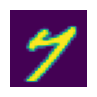

In [15]:
show_image(seven_ts[1])

In [16]:
stacked_sevens = torch.stack(seven_ts).float()/255
stacked_threes = torch.stack(three_ts).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [25]:
stacked_sevens[1].shape

torch.Size([28, 28])

In [26]:
stacked_threes.ndim  # tensor's rank is 3

3

<Axes: >

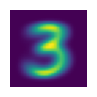

In [27]:
# let's compute the avg of a pixel over all images
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

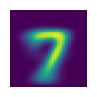

In [28]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<Axes: >

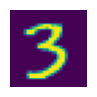

In [29]:
# let's pick an arbitrary 3 and measure its distance from our "ideal digits"
a_3 = stacked_threes[1]
show_image(a_3)

In [30]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [31]:
a_7 = stacked_sevens[1]
dist_7_abs = (a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1304), tensor(0.2585))

In [32]:
import torch.nn.functional as F
F.l1_loss(a_3.float(), mean3)

tensor(0.1114)

In [33]:
F.mse_loss(a_3, mean7).sqrt()

tensor(0.3021)

In [34]:
valid_3_tens = torch.stack(
    [tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]
)
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack(
    [tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]
)
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [35]:

def mnist_distance(a,b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [36]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [37]:
# 1010 28 28
#     28 28

# --------------- BROADCASTING RULES -------------------:
# - each tensor has at least one dimension
# - after shifting the dimensions to the right; 
# the dimension sizes must either be equal, one of them is 1 or doesn't exist 

In [38]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [40]:
is_3(valid_3_tens).float().mean()

tensor(0.9168)

In [41]:
accuracy_3s =      is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [49]:
is_3(a_7), is_3(a_7).float()

(tensor(False), tensor(0.))

### Stochastic Gradient Descent (SGD)

In [87]:
# initalize the weights
# make predictions based on those weights
# calculate the performance of the model; that is, calc. loss
# calculate gradient; how changing weight would change(decrease) the loss
# tweak the weights by lil amount based on calculated gradient 
# go back to step 2 and repeat the process until you are satisfied with the model performance


In [ ]:
# Initialize: we initialize the parameters to random values
# Loss: testing the effectiveness of current weight assignment in terms
#       actual performance(loss)
# Step: a simple way to figure out whether a weight is to be increased or decreased a bit
# Stop: deciding whether to train the model more or stop 

#### A simple example

In [50]:
def f(x): return x**2

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_function(func, x_label='x', y_label='y', title=None, range=(-10, 10), resolution=400):
    """
    Plots a mathematical function.

    Parameters:
    - func: The mathematical function to plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - title (str): The title of the plot.
    - range (tuple): The range of x values to plot.
    - resolution (int): The number of points to generate between the range.
    """
    # Generate x values
    x = np.linspace(range[0], range[1], resolution)

    # Generate y values
    y = func(x)

    # Create the plot
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if title:
        plt.title(title)
    plt.show()

# Example usage
# def my_function(x):
#     return x**2

# plot_function(my_function, 'x', 'x**2', 'Plot of f(x) = x**2', range=(-10, 10))


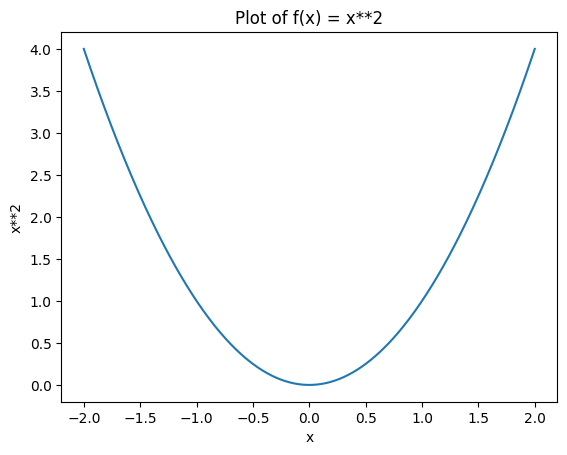

In [52]:
plot_function(f, 'x', 'x**2', 'Plot of f(x) = x**2', range=(-2, 2))

In [53]:
xt = tensor(3.).requires_grad_()

In [54]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [55]:
yt.backward()

In [56]:
xt.grad

tensor(6.)

In [57]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [58]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [59]:
yt.backward()

In [60]:
xt.grad

tensor([ 6.,  8., 20.])

#### Stepping with a learning rate

In [109]:
# w -=gradient(w) * lr

# this is known as stepping your parameters, using an optimizer step

### An end-to-end SGD example

In [61]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

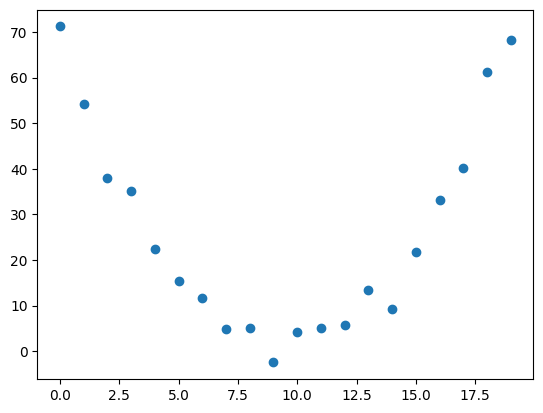

In [62]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [117]:
# we try to predict a function by observing the plotted data.
# looks like a quadratic;
# a*(t**2) + b*t + c

In [63]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

In [119]:
# we are trying to predict the best quadratic function to describe our data.
# which implies the best values for parameters a,b and c

# if we can do this, we can apply same approach to other complex functions

In [64]:
# for continous data it's common to use mean squared error as loss function

def mse(preds, targets): return ((preds-targets)**2).mean()

In [65]:
# Step 1: Initalize the parameters randomly
params = torch.randn(3).requires_grad_()

In [66]:
params

tensor([1.3573, 0.9828, 0.2229], requires_grad=True)

In [67]:
#hide
orig_params = params.clone()

In [68]:
# Step 2: make predictions with intialized parameters
preds = f(time, params)

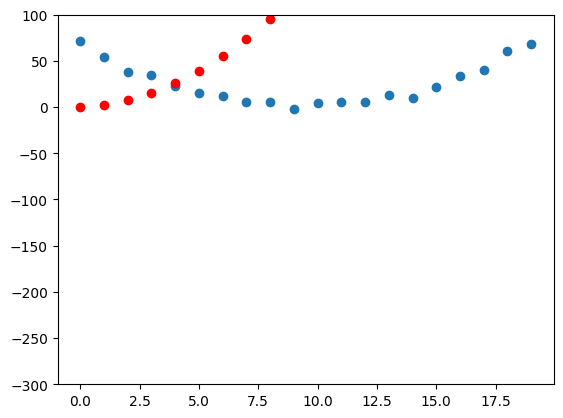

In [69]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

In [70]:
# Step 3: Calculate the loss
loss = mse(preds, speed)
loss

tensor(46997.7891, grad_fn=<MeanBackward0>)

In [71]:
# Step 4: calculate the gradients
loss.backward()
params.grad

tensor([72218.2188,  4652.6719,   302.5263])

In [72]:
params.grad * 1e-5

tensor([0.7222, 0.0465, 0.0030])

In [73]:
params

tensor([1.3573, 0.9828, 0.2229], requires_grad=True)

In [74]:
# Step 5: step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [75]:
preds = f(time, params)
mse(preds, speed)

tensor(9420.6426, grad_fn=<MeanBackward0>)

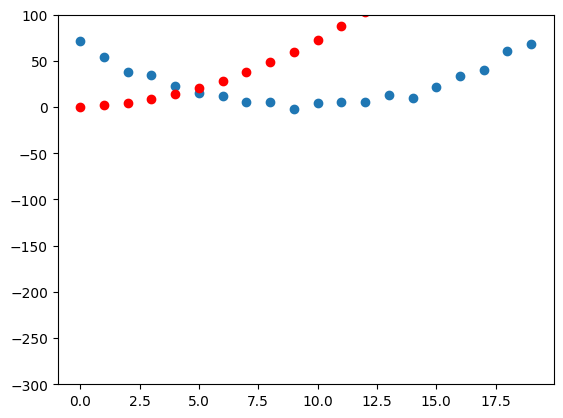

In [76]:
show_preds(preds)

In [77]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [149]:
# Step 6: Repeat the process

In [78]:
for i in range(10): apply_step(params)

9420.642578125
2309.892333984375
964.3165893554688
709.688232421875
661.5003662109375
652.37744140625
650.646728515625
650.3148193359375
650.24755859375
650.2305908203125


In [79]:
#hide 
params = orig_params.detach().requires_grad_()

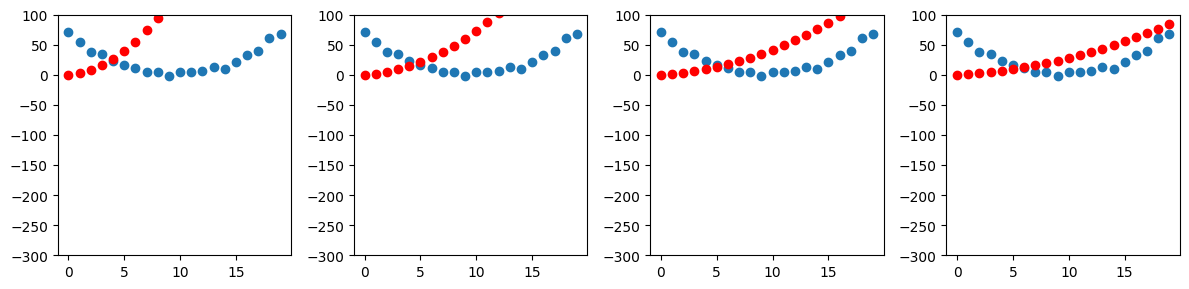

In [80]:
_, axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [156]:
# Step 7: Stop

## MNIST Loss Function

In [81]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [82]:
# we need label for each image; we use 1 for 3s and 0 for 7s
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [83]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [84]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [85]:
# we need to initialize weights randomly for every pixel
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [86]:
weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [87]:
# bias
bias = init_params(1)
bias

tensor([-0.2227], requires_grad=True)

In [88]:
# y = w*x + b
(train_x[0]*weights.T).sum() + bias

tensor([8.3025], grad_fn=<AddBackward0>)

In [89]:
(train_x[0]*weights).shape

torch.Size([784, 784])

In [90]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds, preds.shape

(tensor([[ 8.3025],
         [10.6991],
         [-6.3871],
         ...,
         [ 3.3146],
         [ 9.1373],
         [ 2.4997]], grad_fn=<AddBackward0>),
 torch.Size([12396, 1]))

In [91]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [92]:
corrects.float().mean().item()

0.6790093779563904

In [93]:
# change in accuracy for a small change in weights
with torch.no_grad(): weights[0] *= 1.0001

In [94]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.6790093779563904

In [95]:
corrects.float().mean()

tensor(0.6790)

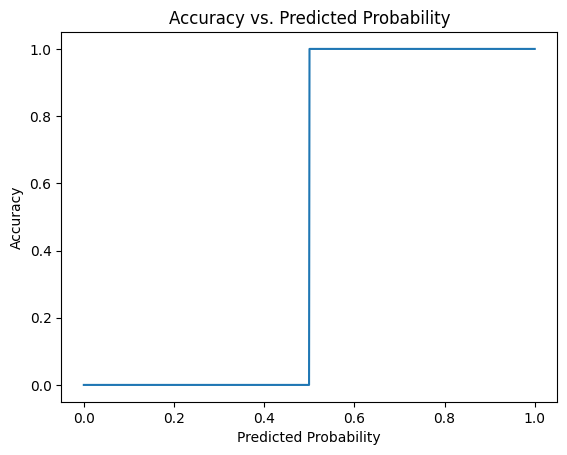

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated probability scores
probabilities = np.linspace(0, 1, 1000)

# Accuracy function using 0.5 as threshold
accuracy = np.where(probabilities > 0.5, 1, 0)

# Plot
plt.plot(probabilities, accuracy)
plt.title("Accuracy vs. Predicted Probability")
plt.xlabel("Predicted Probability")
plt.ylabel("Accuracy")
plt.show()


In [97]:
# accuracy is a function that is constant almost everywhere (except at 0.5);
# so it's derivative is zero almost everywhere and infinity at the threshold(0.5)
# therefore, useless to use it as loss function in our case

In [116]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

In [117]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [118]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [119]:
mnist_loss(prds, trgts)

tensor(0.4333)

In [120]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.2333)

### Sigmoid function

In [121]:
def sigmoid(x): return 1/(1+torch.exp(-x))  # range: (0,1)

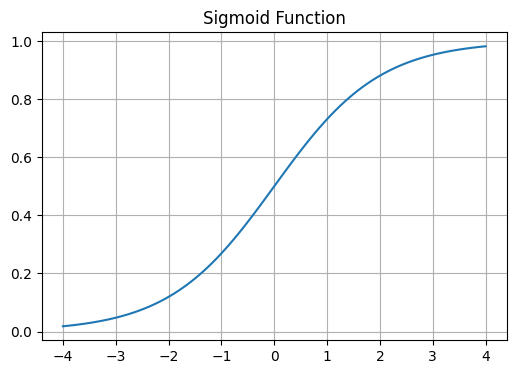

In [122]:
# Generate a tensor from -4 to 4
x = torch.linspace(-4, 4, 100)

# Apply the sigmoid function
y = sigmoid(x)

# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(x.numpy(), y.numpy())
plt.title('Sigmoid Function')
plt.grid(True)
plt.show()

In [123]:
# update mnist_loss function 
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

#### SGD and Mini-batches 

In [124]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([11,  8,  1,  6,  9]),
 tensor([14,  0,  7,  2,  3]),
 tensor([12, 10, 13,  5,  4])]

In [126]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [127]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([23,  1,  8, 21,  0, 22]), ('x', 'b', 'i', 'v', 'a', 'w')),
 (tensor([17,  7, 11,  6, 16,  3]), ('r', 'h', 'l', 'g', 'q', 'd')),
 (tensor([20,  5, 13,  9, 24,  2]), ('u', 'f', 'n', 'j', 'y', 'c')),
 (tensor([12, 15, 19, 18,  4, 25]), ('m', 'p', 't', 's', 'e', 'z')),
 (tensor([10, 14]), ('k', 'o'))]

# Putting it all together 

In [128]:
# Initialize our parameters
weights = init_params((28*28, 1))
bias = init_params(1)

In [129]:
# create dataloader
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [135]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [136]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [137]:
preds = linear1(batch)
preds

tensor([[ -5.4338],
        [-10.9638],
        [ -8.0728],
        [-11.2497]], grad_fn=<AddBackward0>)

In [138]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9988, grad_fn=<MeanBackward0>)

In [139]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0002), tensor([-0.0012]))

In [140]:
# let's put that all in a function
def calc_grad(xb,yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    

In [141]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0003), tensor([-0.0023]))

In [142]:
# what happens if call them twice
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0005), tensor([-0.0035]))

In [143]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [144]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [145]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [146]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [147]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [148]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [149]:
validate_epoch(linear1)

0.2096

In [150]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)


0.2096

In [152]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 0.2096 

In [ ]:
# need to redo this; unnecessary complexity is there in this chapter

In [ ]:
# let's try once more:

# 1. Preprocessing mnist dataset
# 2. initializing random weights and biases: w & b
# 3. making predictions: w.x + b
# 4. calculating loss; start with mse and maybe use sigmoid as activation function
# 5. backward pass; calculating gradients
# 6. updating parameters
# 7. repeat the steps from 3 

In [5]:
import torch 

In [1]:
from tensorflow.keras.datasets import mnist
(train_imgs, train_labels), (test_imgs, test_labels) = mnist.load_data()

In [2]:
train_imgs.shape

(60000, 28, 28)

In [3]:
train_labels.shape

(60000,)

In [13]:
tr_imgs_t = torch.tensor(train_imgs)

In [15]:
tr_imgs_t[0].shape

torch.Size([28, 28])

In [12]:
torch.tensor(train_imgs).view(-1, 28*28).shape

torch.Size([60000, 784])

In [34]:
#hide_output
import pandas as pd
t = tr_imgs_t[0]
df = pd.DataFrame(t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0
